In [ ]:
# Install required packages (if not already installed)
!pip install scanpy anndata seaborn scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scanpy as sc  # For scRNA-seq analysis
import anndata       # For handling AnnData format
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")

# Check versions to ensure compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Anndata version: {anndata.__version__}")

Scanpy version: 1.11.0
Anndata version: 0.11.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file path (Change this if needed)
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'

# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")

AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


In [ ]:
# Step 2: Preprocess the Data
# Filter out low-quality genes and cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# Step 2: Explore Metadata Columns
print("Available Metadata Columns:", adata.obs.columns)

Available Metadata Columns: Index(['week_stage', 'n_genes'], dtype='object')


In [ ]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Scale the data
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


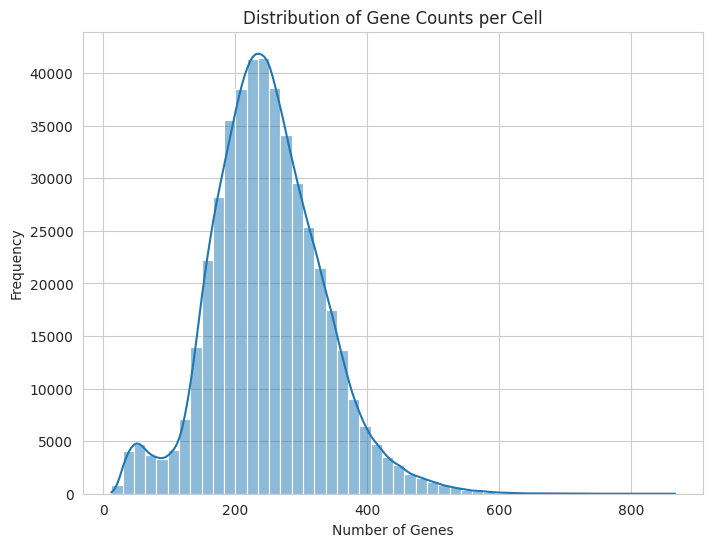

In [ ]:
# Step 3: Exploratory Data Analysis
plt.figure(figsize=(8,6))
# Recalculate n_genes_by_counts after preprocessing
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True)
plt.title("Distribution of Gene Counts per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Frequency")
plt.show()

In [ ]:
!pip install leidenalg --quiet
import igraph as ig
# Step 4: Perform Clustering (if Cell Type Labels are Missing)
if 'cell_type' not in adata.obs.columns:
    print("No cell_type column found. Performing clustering...")
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution=0.5)  # Assign clusters
    adata.obs['cell_type'] = adata.obs['leiden']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 91.1 MB/s eta 0:00:00
No cell_type column found. Performing clustering...


<ipython-input-11-20ca4bcff6e2>:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # Assign clusters


In [ ]:
# Step 6: Extract Features and Labels
X = adata.X  # Gene expression matrix
y = adata.obs['cell_type'].astype(str)  # Labels (now updated)

In [ ]:
# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Step 8: Train a Machine Learning Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 9: Evaluate the Model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9535464211618258
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10003
           1       0.90      0.98      0.94      5266
          10       0.93      0.97      0.95      2941
          11       0.95      0.99      0.97      2780
          12       0.95      0.94      0.95      2736
          13       0.93      0.85      0.89      2592
          14       0.97      0.97      0.97      2465
          15       0.99      1.00      0.99      2283
          16       0.99      0.95      0.97      2185
          17       0.97      0.89      0.93      2105
          18       0.96      0.95      0.96      2061
          19       0.98      0.92      0.95      1878
           2       0.96      0.99      0.98      5020
          20       0.98      0.99      0.98      1825
          21       0.94      0.94      0.94      1643
          22       0.98      0.94      0.96      1607
          23       0.97      0.99      0.98      148

In [ ]:
# Step 10: Identify Key Biomarkers
feature_importances = pd.DataFrame({'gene': adata.var_names, 'importance': clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

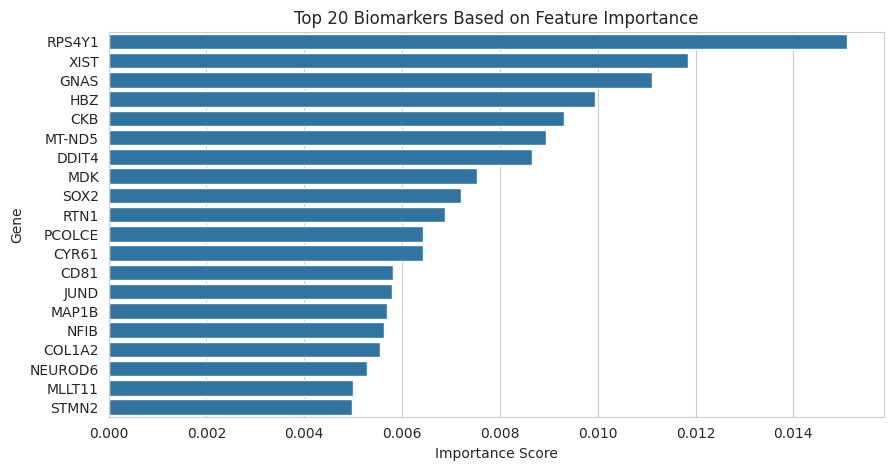

In [ ]:
# Step 11: Visualize Top Biomarkers
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importances['importance'][:20], y=feature_importances['gene'][:20])
plt.title("Top 20 Biomarkers Based on Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.show()